<h1>Autoencoders

<h2>Importing required libraries

In [11]:
import torch
import random
import numpy as np
import torch.nn as nn
import tensorflow as tf
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from keras.datasets import fashion_mnist
from torch.optim.lr_scheduler import ExponentialLR

<h2>Initializing device details and Importing the dataset

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

<h2>Displaying sample images from dataset

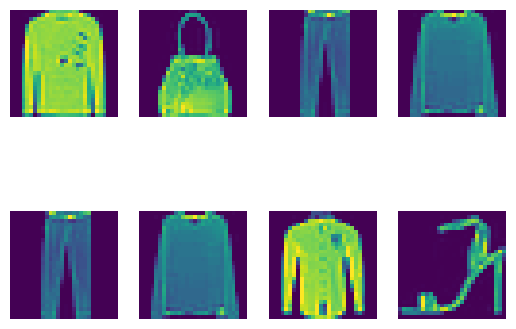

In [13]:
def displayImages(imageList, rows, columns):
    fig, grid = plt.subplots(rows,columns) 
    for i in range(rows):
        for j in range(columns):
            grid[i,j].axis('off')
            grid[i,j].imshow(np.reshape(imageList[(i-1)*rows+j], (28,28)))

numSamples = 8
randomIndices = random.sample(range(0, len(xTrain)), numSamples)
displayImages(list(np.array(xTrain)[randomIndices]), 2, 4)

<h2>Dataset Preprocessing

In [14]:
length, breadth = xTrain[0].shape
flattenDim = length * breadth
#xTrain = torch.FloatTensor(np.round(xTrain / 27).astype(int)).to(device)
xTrain = np.round(xTrain / 27).astype(int)
xTest = np.round(xTest / 27).astype(int)
xTrainFlat = torch.FloatTensor(np.reshape(xTrain, (-1,flattenDim))).to(device)
xTestFlat = np.reshape(xTest, (-1,flattenDim)) 

<h2>Initializing TrainLoader and TestLoader functions

In [15]:
trainLoader = DataLoader(dataset = xTrainFlat, batch_size = 32, shuffle = True)
testLoader = DataLoader(dataset = xTestFlat, batch_size = 16, shuffle = True)

<h2>Defining Variational AutoEncoder class

In [16]:
latentSize = 20

class variationalAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 40)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 784)
        )
    def reparameterization(self, mean, logVariance):
        standardDeviation = torch.exp(0.5 * logVariance)
        epsilonValue = torch.randn_like(standardDeviation)
        chosenSample = mean + (epsilonValue * standardDeviation)
        return chosenSample

    def forward(self, x):
        encoded = self.encoder(x)
        mean, logVariance = torch.split(encoded, 20, dim = 2)
        z = self.reparameterization(mean, logVariance)
        reconstructed = self.decoder(z)
        return mean, logVariance, reconstructed

<h2>Defining the ELBO loss function

In [17]:
def lossFunction(L2loss, Mean, logVariance):
    MSELoss = L2loss
    klDivergence = torch.mean(-0.5*torch.sum(1 + logVariance - Mean.pow(2) - logVariance.exp(),dim=1))
    totalLoss = MSELoss + klDivergence
    return totalLoss

<h2>Training the AutoEncoder model

In [18]:
NUM_EPOCHS = 300
vaeModel = variationalAE().to(device)
modelParameters = list(vaeModel.parameters())
criterion = nn.MSELoss()
optimizer = optim.SGD(modelParameters, lr=(1e-3), momentum=0.7)

epochLoss = []
epochList = np.arange(0, NUM_EPOCHS, dtype=int)

encoderOutputs = []
decoderOutputs = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Epochs"):
    losses = []
    
    for batchIndex, batchImage in tqdm(enumerate(trainLoader), desc="Batches", leave=False):
        batchImage = batchImage.to(device)
        batchImage = batchImage.unsqueeze(1)
        obtainedMean, obtainedLogVariance, reconstructedImage = vaeModel(batchImage)
        reconstructionLoss = criterion(reconstructedImage, batchImage)
        loss = lossFunction(reconstructionLoss, obtainedMean, obtainedLogVariance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())

    print("Epoch: ", epoch+1, "| Average loss: ", np.round(np.average(losses), 3), "| Lowest Loss: ", np.round(np.amin(losses), 3), "| Reconstruction Loss: ", np.round(reconstructionLoss.item(), 3))
    epochLoss.append(np.round(np.amin(losses), 3))
    torch.save(vaeModel.state_dict(), "vae.pth")


Training Epochs:   0%|          | 1/300 [00:07<38:18,  7.69s/it]

Epoch:  1 | Average loss:  8.874 | Lowest Loss:  5.01 | Reconstruction Loss:  6.173


Training Epochs:   1%|          | 2/300 [00:15<38:01,  7.66s/it]

Epoch:  2 | Average loss:  6.33 | Lowest Loss:  4.887 | Reconstruction Loss:  5.578


Training Epochs:   1%|          | 3/300 [00:22<37:51,  7.65s/it]

Epoch:  3 | Average loss:  5.261 | Lowest Loss:  4.116 | Reconstruction Loss:  4.478


Training Epochs:   1%|▏         | 4/300 [00:30<37:36,  7.62s/it]

Epoch:  4 | Average loss:  4.818 | Lowest Loss:  3.579 | Reconstruction Loss:  3.709


Training Epochs:   2%|▏         | 5/300 [00:38<37:26,  7.61s/it]

Epoch:  5 | Average loss:  4.567 | Lowest Loss:  3.518 | Reconstruction Loss:  4.458


Training Epochs:   2%|▏         | 6/300 [00:45<37:17,  7.61s/it]

Epoch:  6 | Average loss:  4.473 | Lowest Loss:  3.373 | Reconstruction Loss:  4.008


Training Epochs:   2%|▏         | 7/300 [00:53<37:14,  7.62s/it]

Epoch:  7 | Average loss:  4.398 | Lowest Loss:  3.337 | Reconstruction Loss:  3.563


Training Epochs:   3%|▎         | 8/300 [01:00<36:57,  7.59s/it]

Epoch:  8 | Average loss:  4.278 | Lowest Loss:  3.194 | Reconstruction Loss:  3.415


Training Epochs:   3%|▎         | 9/300 [01:08<36:46,  7.58s/it]

Epoch:  9 | Average loss:  4.118 | Lowest Loss:  3.103 | Reconstruction Loss:  3.448


Training Epochs:   3%|▎         | 10/300 [01:16<36:39,  7.59s/it]

Epoch:  10 | Average loss:  4.0 | Lowest Loss:  3.074 | Reconstruction Loss:  3.439


Training Epochs:   4%|▎         | 11/300 [01:23<36:36,  7.60s/it]

Epoch:  11 | Average loss:  3.911 | Lowest Loss:  3.086 | Reconstruction Loss:  3.697


Training Epochs:   4%|▍         | 12/300 [01:31<36:33,  7.62s/it]

Epoch:  12 | Average loss:  3.824 | Lowest Loss:  2.878 | Reconstruction Loss:  3.541


Training Epochs:   4%|▍         | 13/300 [01:38<36:23,  7.61s/it]

Epoch:  13 | Average loss:  3.73 | Lowest Loss:  2.947 | Reconstruction Loss:  3.6


Training Epochs:   5%|▍         | 14/300 [01:46<36:05,  7.57s/it]

Epoch:  14 | Average loss:  3.631 | Lowest Loss:  2.759 | Reconstruction Loss:  3.199


Training Epochs:   5%|▌         | 15/300 [01:53<35:50,  7.54s/it]

Epoch:  15 | Average loss:  3.541 | Lowest Loss:  2.742 | Reconstruction Loss:  2.991


Training Epochs:   5%|▌         | 16/300 [02:01<35:41,  7.54s/it]

Epoch:  16 | Average loss:  3.472 | Lowest Loss:  2.662 | Reconstruction Loss:  2.805


Training Epochs:   6%|▌         | 17/300 [02:09<35:54,  7.61s/it]

Epoch:  17 | Average loss:  3.418 | Lowest Loss:  2.679 | Reconstruction Loss:  2.964


Training Epochs:   6%|▌         | 18/300 [02:16<35:42,  7.60s/it]

Epoch:  18 | Average loss:  3.373 | Lowest Loss:  2.64 | Reconstruction Loss:  3.062


Training Epochs:   6%|▋         | 19/300 [02:24<35:30,  7.58s/it]

Epoch:  19 | Average loss:  3.334 | Lowest Loss:  2.565 | Reconstruction Loss:  2.966


Training Epochs:   7%|▋         | 20/300 [02:31<35:23,  7.58s/it]

Epoch:  20 | Average loss:  3.301 | Lowest Loss:  2.564 | Reconstruction Loss:  2.324


Training Epochs:   7%|▋         | 21/300 [02:39<35:15,  7.58s/it]

Epoch:  21 | Average loss:  3.268 | Lowest Loss:  2.573 | Reconstruction Loss:  3.051


Training Epochs:   7%|▋         | 22/300 [02:47<35:06,  7.58s/it]

Epoch:  22 | Average loss:  3.235 | Lowest Loss:  2.604 | Reconstruction Loss:  2.734


Training Epochs:   8%|▊         | 23/300 [02:54<34:55,  7.57s/it]

Epoch:  23 | Average loss:  3.208 | Lowest Loss:  2.514 | Reconstruction Loss:  2.689


Training Epochs:   8%|▊         | 24/300 [03:02<34:51,  7.58s/it]

Epoch:  24 | Average loss:  3.181 | Lowest Loss:  2.319 | Reconstruction Loss:  2.731


Training Epochs:   8%|▊         | 25/300 [03:09<34:43,  7.58s/it]

Epoch:  25 | Average loss:  3.158 | Lowest Loss:  2.476 | Reconstruction Loss:  2.731


Training Epochs:   9%|▊         | 26/300 [03:17<34:30,  7.56s/it]

Epoch:  26 | Average loss:  3.133 | Lowest Loss:  2.481 | Reconstruction Loss:  2.124


Training Epochs:   9%|▉         | 27/300 [03:24<34:23,  7.56s/it]

Epoch:  27 | Average loss:  3.113 | Lowest Loss:  2.398 | Reconstruction Loss:  2.465


Training Epochs:   9%|▉         | 28/300 [03:32<34:20,  7.57s/it]

Epoch:  28 | Average loss:  3.094 | Lowest Loss:  2.437 | Reconstruction Loss:  2.487


Training Epochs:  10%|▉         | 29/300 [03:40<34:18,  7.59s/it]

Epoch:  29 | Average loss:  3.076 | Lowest Loss:  2.401 | Reconstruction Loss:  2.412


Training Epochs:  10%|█         | 30/300 [03:47<34:11,  7.60s/it]

Epoch:  30 | Average loss:  3.057 | Lowest Loss:  2.463 | Reconstruction Loss:  2.565


Training Epochs:  10%|█         | 31/300 [03:55<33:53,  7.56s/it]

Epoch:  31 | Average loss:  3.046 | Lowest Loss:  2.398 | Reconstruction Loss:  2.371


Training Epochs:  11%|█         | 32/300 [04:02<33:45,  7.56s/it]

Epoch:  32 | Average loss:  3.029 | Lowest Loss:  2.389 | Reconstruction Loss:  2.801


Training Epochs:  11%|█         | 33/300 [04:10<33:42,  7.58s/it]

Epoch:  33 | Average loss:  3.017 | Lowest Loss:  2.366 | Reconstruction Loss:  2.742


Training Epochs:  11%|█▏        | 34/300 [04:17<33:33,  7.57s/it]

Epoch:  34 | Average loss:  3.003 | Lowest Loss:  2.424 | Reconstruction Loss:  2.257


Training Epochs:  12%|█▏        | 35/300 [04:25<33:25,  7.57s/it]

Epoch:  35 | Average loss:  2.99 | Lowest Loss:  2.338 | Reconstruction Loss:  2.628


Training Epochs:  12%|█▏        | 36/300 [04:33<33:19,  7.57s/it]

Epoch:  36 | Average loss:  2.978 | Lowest Loss:  2.374 | Reconstruction Loss:  2.557


Training Epochs:  12%|█▏        | 37/300 [04:40<33:11,  7.57s/it]

Epoch:  37 | Average loss:  2.965 | Lowest Loss:  2.353 | Reconstruction Loss:  2.903


Training Epochs:  13%|█▎        | 38/300 [04:48<33:03,  7.57s/it]

Epoch:  38 | Average loss:  2.954 | Lowest Loss:  2.277 | Reconstruction Loss:  2.208


Training Epochs:  13%|█▎        | 39/300 [04:55<32:49,  7.55s/it]

Epoch:  39 | Average loss:  2.941 | Lowest Loss:  2.311 | Reconstruction Loss:  2.376


Training Epochs:  13%|█▎        | 40/300 [05:03<32:47,  7.57s/it]

Epoch:  40 | Average loss:  2.93 | Lowest Loss:  2.367 | Reconstruction Loss:  2.379


Training Epochs:  14%|█▎        | 41/300 [05:10<32:32,  7.54s/it]

Epoch:  41 | Average loss:  2.92 | Lowest Loss:  2.362 | Reconstruction Loss:  2.635


Training Epochs:  14%|█▍        | 42/300 [05:18<32:34,  7.58s/it]

Epoch:  42 | Average loss:  2.908 | Lowest Loss:  2.253 | Reconstruction Loss:  2.45


Training Epochs:  14%|█▍        | 43/300 [05:25<32:24,  7.57s/it]

Epoch:  43 | Average loss:  2.899 | Lowest Loss:  2.258 | Reconstruction Loss:  2.276


Training Epochs:  15%|█▍        | 44/300 [05:33<32:24,  7.60s/it]

Epoch:  44 | Average loss:  2.887 | Lowest Loss:  2.23 | Reconstruction Loss:  2.411


Training Epochs:  15%|█▌        | 45/300 [05:41<32:11,  7.57s/it]

Epoch:  45 | Average loss:  2.878 | Lowest Loss:  2.315 | Reconstruction Loss:  2.543


Training Epochs:  15%|█▌        | 46/300 [05:48<32:04,  7.58s/it]

Epoch:  46 | Average loss:  2.868 | Lowest Loss:  2.276 | Reconstruction Loss:  2.642


Training Epochs:  16%|█▌        | 47/300 [05:56<31:53,  7.56s/it]

Epoch:  47 | Average loss:  2.86 | Lowest Loss:  2.221 | Reconstruction Loss:  2.376


Training Epochs:  16%|█▌        | 48/300 [06:03<31:42,  7.55s/it]

Epoch:  48 | Average loss:  2.851 | Lowest Loss:  2.248 | Reconstruction Loss:  2.562


Training Epochs:  16%|█▋        | 49/300 [06:11<31:33,  7.54s/it]

Epoch:  49 | Average loss:  2.843 | Lowest Loss:  2.188 | Reconstruction Loss:  2.2


Training Epochs:  17%|█▋        | 50/300 [06:18<31:30,  7.56s/it]

Epoch:  50 | Average loss:  2.835 | Lowest Loss:  2.144 | Reconstruction Loss:  2.633


Training Epochs:  17%|█▋        | 51/300 [06:26<31:20,  7.55s/it]

Epoch:  51 | Average loss:  2.827 | Lowest Loss:  2.279 | Reconstruction Loss:  2.499


Training Epochs:  17%|█▋        | 52/300 [06:34<31:15,  7.56s/it]

Epoch:  52 | Average loss:  2.821 | Lowest Loss:  2.153 | Reconstruction Loss:  2.241


Training Epochs:  18%|█▊        | 53/300 [06:41<31:05,  7.55s/it]

Epoch:  53 | Average loss:  2.816 | Lowest Loss:  2.246 | Reconstruction Loss:  2.538


Training Epochs:  18%|█▊        | 54/300 [06:49<30:54,  7.54s/it]

Epoch:  54 | Average loss:  2.805 | Lowest Loss:  2.172 | Reconstruction Loss:  2.503


Training Epochs:  18%|█▊        | 55/300 [06:56<30:43,  7.52s/it]

Epoch:  55 | Average loss:  2.799 | Lowest Loss:  2.235 | Reconstruction Loss:  2.545


Training Epochs:  19%|█▊        | 56/300 [07:04<30:33,  7.52s/it]

Epoch:  56 | Average loss:  2.792 | Lowest Loss:  2.208 | Reconstruction Loss:  2.564


Training Epochs:  19%|█▉        | 57/300 [07:11<30:29,  7.53s/it]

Epoch:  57 | Average loss:  2.785 | Lowest Loss:  2.156 | Reconstruction Loss:  2.212


Training Epochs:  19%|█▉        | 58/300 [07:19<30:36,  7.59s/it]

Epoch:  58 | Average loss:  2.781 | Lowest Loss:  2.122 | Reconstruction Loss:  2.475


Training Epochs:  20%|█▉        | 59/300 [07:26<30:29,  7.59s/it]

Epoch:  59 | Average loss:  2.773 | Lowest Loss:  2.188 | Reconstruction Loss:  1.957


Training Epochs:  20%|██        | 60/300 [07:34<30:22,  7.59s/it]

Epoch:  60 | Average loss:  2.768 | Lowest Loss:  2.071 | Reconstruction Loss:  2.033


Training Epochs:  20%|██        | 61/300 [07:42<30:15,  7.60s/it]

Epoch:  61 | Average loss:  2.76 | Lowest Loss:  2.118 | Reconstruction Loss:  2.412


Training Epochs:  21%|██        | 62/300 [07:49<30:02,  7.58s/it]

Epoch:  62 | Average loss:  2.757 | Lowest Loss:  2.185 | Reconstruction Loss:  2.365


Training Epochs:  21%|██        | 63/300 [07:57<29:55,  7.57s/it]

Epoch:  63 | Average loss:  2.752 | Lowest Loss:  2.155 | Reconstruction Loss:  2.184


Training Epochs:  21%|██▏       | 64/300 [08:04<29:43,  7.56s/it]

Epoch:  64 | Average loss:  2.747 | Lowest Loss:  2.131 | Reconstruction Loss:  2.538


Training Epochs:  22%|██▏       | 65/300 [08:12<29:33,  7.55s/it]

Epoch:  65 | Average loss:  2.741 | Lowest Loss:  2.179 | Reconstruction Loss:  2.4


Training Epochs:  22%|██▏       | 66/300 [08:19<29:26,  7.55s/it]

Epoch:  66 | Average loss:  2.735 | Lowest Loss:  2.21 | Reconstruction Loss:  2.054


Training Epochs:  22%|██▏       | 67/300 [08:27<29:24,  7.57s/it]

Epoch:  67 | Average loss:  2.73 | Lowest Loss:  2.101 | Reconstruction Loss:  2.342


Training Epochs:  23%|██▎       | 68/300 [08:35<29:18,  7.58s/it]

Epoch:  68 | Average loss:  2.727 | Lowest Loss:  2.173 | Reconstruction Loss:  2.323


Training Epochs:  23%|██▎       | 69/300 [08:42<29:07,  7.57s/it]

Epoch:  69 | Average loss:  2.72 | Lowest Loss:  2.156 | Reconstruction Loss:  2.844


Training Epochs:  23%|██▎       | 70/300 [08:50<29:04,  7.59s/it]

Epoch:  70 | Average loss:  2.716 | Lowest Loss:  2.157 | Reconstruction Loss:  2.386


Training Epochs:  24%|██▎       | 71/300 [08:57<28:54,  7.57s/it]

Epoch:  71 | Average loss:  2.714 | Lowest Loss:  2.019 | Reconstruction Loss:  1.988


Training Epochs:  24%|██▍       | 72/300 [09:05<28:46,  7.57s/it]

Epoch:  72 | Average loss:  2.708 | Lowest Loss:  2.119 | Reconstruction Loss:  2.516


Training Epochs:  24%|██▍       | 73/300 [09:12<28:35,  7.56s/it]

Epoch:  73 | Average loss:  2.704 | Lowest Loss:  2.125 | Reconstruction Loss:  2.162


Training Epochs:  25%|██▍       | 74/300 [09:20<28:25,  7.54s/it]

Epoch:  74 | Average loss:  2.7 | Lowest Loss:  2.137 | Reconstruction Loss:  2.098


Training Epochs:  25%|██▌       | 75/300 [09:28<28:22,  7.57s/it]

Epoch:  75 | Average loss:  2.696 | Lowest Loss:  2.082 | Reconstruction Loss:  1.946


Training Epochs:  25%|██▌       | 76/300 [09:35<28:12,  7.56s/it]

Epoch:  76 | Average loss:  2.692 | Lowest Loss:  2.142 | Reconstruction Loss:  2.063


Training Epochs:  26%|██▌       | 77/300 [09:43<28:05,  7.56s/it]

Epoch:  77 | Average loss:  2.688 | Lowest Loss:  2.135 | Reconstruction Loss:  2.179


Training Epochs:  26%|██▌       | 78/300 [09:50<27:56,  7.55s/it]

Epoch:  78 | Average loss:  2.685 | Lowest Loss:  2.136 | Reconstruction Loss:  2.026


Training Epochs:  26%|██▋       | 79/300 [09:58<27:58,  7.59s/it]

Epoch:  79 | Average loss:  2.68 | Lowest Loss:  2.111 | Reconstruction Loss:  2.108


Training Epochs:  27%|██▋       | 80/300 [10:05<27:46,  7.57s/it]

Epoch:  80 | Average loss:  2.677 | Lowest Loss:  2.092 | Reconstruction Loss:  1.954


Training Epochs:  27%|██▋       | 81/300 [10:13<27:43,  7.60s/it]

Epoch:  81 | Average loss:  2.674 | Lowest Loss:  2.031 | Reconstruction Loss:  2.263


Training Epochs:  27%|██▋       | 82/300 [10:21<27:38,  7.61s/it]

Epoch:  82 | Average loss:  2.671 | Lowest Loss:  2.129 | Reconstruction Loss:  2.348


Training Epochs:  28%|██▊       | 83/300 [10:28<27:32,  7.61s/it]

Epoch:  83 | Average loss:  2.666 | Lowest Loss:  2.094 | Reconstruction Loss:  2.342


Training Epochs:  28%|██▊       | 84/300 [10:36<27:22,  7.61s/it]

Epoch:  84 | Average loss:  2.663 | Lowest Loss:  2.132 | Reconstruction Loss:  1.999


Training Epochs:  28%|██▊       | 85/300 [10:43<27:10,  7.58s/it]

Epoch:  85 | Average loss:  2.66 | Lowest Loss:  2.151 | Reconstruction Loss:  2.53


Training Epochs:  29%|██▊       | 86/300 [10:51<26:59,  7.57s/it]

Epoch:  86 | Average loss:  2.658 | Lowest Loss:  2.065 | Reconstruction Loss:  2.139


Training Epochs:  29%|██▉       | 87/300 [10:58<26:47,  7.55s/it]

Epoch:  87 | Average loss:  2.654 | Lowest Loss:  2.007 | Reconstruction Loss:  2.363


Training Epochs:  29%|██▉       | 88/300 [11:06<26:43,  7.57s/it]

Epoch:  88 | Average loss:  2.65 | Lowest Loss:  2.059 | Reconstruction Loss:  2.085


Training Epochs:  30%|██▉       | 89/300 [11:14<26:36,  7.57s/it]

Epoch:  89 | Average loss:  2.647 | Lowest Loss:  2.069 | Reconstruction Loss:  2.163


Training Epochs:  30%|███       | 90/300 [11:21<26:29,  7.57s/it]

Epoch:  90 | Average loss:  2.644 | Lowest Loss:  2.058 | Reconstruction Loss:  2.038


Training Epochs:  30%|███       | 91/300 [11:29<26:13,  7.53s/it]

Epoch:  91 | Average loss:  2.641 | Lowest Loss:  2.017 | Reconstruction Loss:  2.078


Training Epochs:  31%|███       | 92/300 [11:36<26:09,  7.55s/it]

Epoch:  92 | Average loss:  2.636 | Lowest Loss:  2.078 | Reconstruction Loss:  1.997


Training Epochs:  31%|███       | 93/300 [11:44<26:02,  7.55s/it]

Epoch:  93 | Average loss:  2.634 | Lowest Loss:  2.105 | Reconstruction Loss:  1.907


Training Epochs:  31%|███▏      | 94/300 [11:51<26:00,  7.57s/it]

Epoch:  94 | Average loss:  2.632 | Lowest Loss:  1.998 | Reconstruction Loss:  2.283


Training Epochs:  32%|███▏      | 95/300 [11:59<25:54,  7.58s/it]

Epoch:  95 | Average loss:  2.63 | Lowest Loss:  1.994 | Reconstruction Loss:  2.149


Training Epochs:  32%|███▏      | 96/300 [12:07<25:44,  7.57s/it]

Epoch:  96 | Average loss:  2.626 | Lowest Loss:  2.097 | Reconstruction Loss:  2.142


Training Epochs:  32%|███▏      | 97/300 [12:14<25:52,  7.65s/it]

Epoch:  97 | Average loss:  2.623 | Lowest Loss:  2.088 | Reconstruction Loss:  2.308


Training Epochs:  33%|███▎      | 98/300 [12:22<25:41,  7.63s/it]

Epoch:  98 | Average loss:  2.619 | Lowest Loss:  2.099 | Reconstruction Loss:  1.966


Training Epochs:  33%|███▎      | 99/300 [12:30<25:30,  7.62s/it]

Epoch:  99 | Average loss:  2.616 | Lowest Loss:  2.121 | Reconstruction Loss:  1.927


Training Epochs:  33%|███▎      | 100/300 [12:37<25:21,  7.61s/it]

Epoch:  100 | Average loss:  2.612 | Lowest Loss:  2.098 | Reconstruction Loss:  2.256


Training Epochs:  34%|███▎      | 101/300 [12:45<25:14,  7.61s/it]

Epoch:  101 | Average loss:  2.611 | Lowest Loss:  2.05 | Reconstruction Loss:  2.042


Training Epochs:  34%|███▍      | 102/300 [12:52<25:09,  7.62s/it]

Epoch:  102 | Average loss:  2.61 | Lowest Loss:  2.013 | Reconstruction Loss:  1.76


Training Epochs:  34%|███▍      | 103/300 [13:00<24:58,  7.61s/it]

Epoch:  103 | Average loss:  2.606 | Lowest Loss:  2.064 | Reconstruction Loss:  2.335


Training Epochs:  35%|███▍      | 104/300 [13:08<24:46,  7.59s/it]

Epoch:  104 | Average loss:  2.602 | Lowest Loss:  2.072 | Reconstruction Loss:  2.179


Training Epochs:  35%|███▌      | 105/300 [13:15<24:38,  7.58s/it]

Epoch:  105 | Average loss:  2.599 | Lowest Loss:  2.054 | Reconstruction Loss:  2.215


Training Epochs:  35%|███▌      | 106/300 [13:23<24:30,  7.58s/it]

Epoch:  106 | Average loss:  2.597 | Lowest Loss:  2.049 | Reconstruction Loss:  1.886


Training Epochs:  36%|███▌      | 107/300 [13:30<24:26,  7.60s/it]

Epoch:  107 | Average loss:  2.594 | Lowest Loss:  2.113 | Reconstruction Loss:  1.921


Training Epochs:  36%|███▌      | 108/300 [13:38<24:19,  7.60s/it]

Epoch:  108 | Average loss:  2.592 | Lowest Loss:  2.085 | Reconstruction Loss:  2.081


Training Epochs:  36%|███▋      | 109/300 [13:46<24:13,  7.61s/it]

Epoch:  109 | Average loss:  2.589 | Lowest Loss:  1.993 | Reconstruction Loss:  1.971


Training Epochs:  37%|███▋      | 110/300 [13:53<24:05,  7.61s/it]

Epoch:  110 | Average loss:  2.585 | Lowest Loss:  2.043 | Reconstruction Loss:  2.195


Training Epochs:  37%|███▋      | 111/300 [14:01<23:57,  7.60s/it]

Epoch:  111 | Average loss:  2.586 | Lowest Loss:  2.009 | Reconstruction Loss:  1.946


Training Epochs:  37%|███▋      | 112/300 [14:08<23:56,  7.64s/it]

Epoch:  112 | Average loss:  2.582 | Lowest Loss:  2.083 | Reconstruction Loss:  1.926


Training Epochs:  38%|███▊      | 113/300 [14:16<23:50,  7.65s/it]

Epoch:  113 | Average loss:  2.577 | Lowest Loss:  2.04 | Reconstruction Loss:  1.992


Training Epochs:  38%|███▊      | 114/300 [14:24<23:39,  7.63s/it]

Epoch:  114 | Average loss:  2.576 | Lowest Loss:  2.028 | Reconstruction Loss:  2.286


Training Epochs:  38%|███▊      | 115/300 [14:31<23:27,  7.61s/it]

Epoch:  115 | Average loss:  2.575 | Lowest Loss:  1.95 | Reconstruction Loss:  1.935


Training Epochs:  39%|███▊      | 116/300 [14:39<23:16,  7.59s/it]

Epoch:  116 | Average loss:  2.574 | Lowest Loss:  2.078 | Reconstruction Loss:  2.184


Training Epochs:  39%|███▉      | 117/300 [14:46<23:06,  7.58s/it]

Epoch:  117 | Average loss:  2.569 | Lowest Loss:  2.04 | Reconstruction Loss:  2.269


Training Epochs:  39%|███▉      | 118/300 [14:54<22:59,  7.58s/it]

Epoch:  118 | Average loss:  2.569 | Lowest Loss:  1.996 | Reconstruction Loss:  1.805


Training Epochs:  40%|███▉      | 119/300 [15:01<22:48,  7.56s/it]

Epoch:  119 | Average loss:  2.565 | Lowest Loss:  1.989 | Reconstruction Loss:  2.022


Training Epochs:  40%|████      | 120/300 [15:09<22:43,  7.58s/it]

Epoch:  120 | Average loss:  2.563 | Lowest Loss:  2.004 | Reconstruction Loss:  2.11


Training Epochs:  40%|████      | 121/300 [15:17<22:35,  7.57s/it]

Epoch:  121 | Average loss:  2.561 | Lowest Loss:  2.023 | Reconstruction Loss:  2.148


Training Epochs:  41%|████      | 122/300 [15:24<22:31,  7.59s/it]

Epoch:  122 | Average loss:  2.559 | Lowest Loss:  1.973 | Reconstruction Loss:  1.846


Training Epochs:  41%|████      | 123/300 [15:32<22:21,  7.58s/it]

Epoch:  123 | Average loss:  2.556 | Lowest Loss:  1.886 | Reconstruction Loss:  1.563


Training Epochs:  41%|████▏     | 124/300 [15:39<22:10,  7.56s/it]

Epoch:  124 | Average loss:  2.554 | Lowest Loss:  2.037 | Reconstruction Loss:  1.7


Training Epochs:  42%|████▏     | 125/300 [15:47<22:02,  7.56s/it]

Epoch:  125 | Average loss:  2.554 | Lowest Loss:  2.034 | Reconstruction Loss:  1.711


Training Epochs:  42%|████▏     | 126/300 [15:54<21:57,  7.57s/it]

Epoch:  126 | Average loss:  2.548 | Lowest Loss:  2.006 | Reconstruction Loss:  2.061


Training Epochs:  42%|████▏     | 127/300 [16:02<21:56,  7.61s/it]

Epoch:  127 | Average loss:  2.548 | Lowest Loss:  2.021 | Reconstruction Loss:  2.371


Training Epochs:  43%|████▎     | 128/300 [16:10<21:50,  7.62s/it]

Epoch:  128 | Average loss:  2.546 | Lowest Loss:  2.056 | Reconstruction Loss:  1.801


Training Epochs:  43%|████▎     | 129/300 [16:17<21:44,  7.63s/it]

Epoch:  129 | Average loss:  2.544 | Lowest Loss:  2.002 | Reconstruction Loss:  2.107


Training Epochs:  43%|████▎     | 130/300 [16:25<21:36,  7.63s/it]

Epoch:  130 | Average loss:  2.541 | Lowest Loss:  2.005 | Reconstruction Loss:  2.352


Training Epochs:  44%|████▎     | 131/300 [16:33<21:22,  7.59s/it]

Epoch:  131 | Average loss:  2.539 | Lowest Loss:  2.031 | Reconstruction Loss:  2.037


Training Epochs:  44%|████▍     | 132/300 [16:40<21:09,  7.55s/it]

Epoch:  132 | Average loss:  2.537 | Lowest Loss:  1.977 | Reconstruction Loss:  2.356


Training Epochs:  44%|████▍     | 133/300 [16:48<20:59,  7.54s/it]

Epoch:  133 | Average loss:  2.535 | Lowest Loss:  1.989 | Reconstruction Loss:  2.044


Training Epochs:  45%|████▍     | 134/300 [16:55<20:57,  7.58s/it]

Epoch:  134 | Average loss:  2.534 | Lowest Loss:  2.015 | Reconstruction Loss:  2.152


Training Epochs:  45%|████▌     | 135/300 [17:03<20:47,  7.56s/it]

Epoch:  135 | Average loss:  2.531 | Lowest Loss:  1.923 | Reconstruction Loss:  1.608


Training Epochs:  45%|████▌     | 136/300 [17:10<20:41,  7.57s/it]

Epoch:  136 | Average loss:  2.53 | Lowest Loss:  2.036 | Reconstruction Loss:  2.299


Training Epochs:  46%|████▌     | 137/300 [17:18<20:31,  7.56s/it]

Epoch:  137 | Average loss:  2.527 | Lowest Loss:  1.909 | Reconstruction Loss:  2.447


Training Epochs:  46%|████▌     | 138/300 [17:25<20:22,  7.55s/it]

Epoch:  138 | Average loss:  2.525 | Lowest Loss:  1.992 | Reconstruction Loss:  2.006


Training Epochs:  46%|████▋     | 139/300 [17:33<20:20,  7.58s/it]

Epoch:  139 | Average loss:  2.525 | Lowest Loss:  1.998 | Reconstruction Loss:  1.818


Training Epochs:  47%|████▋     | 140/300 [17:41<20:09,  7.56s/it]

Epoch:  140 | Average loss:  2.521 | Lowest Loss:  2.05 | Reconstruction Loss:  1.929


Training Epochs:  47%|████▋     | 141/300 [17:48<20:02,  7.56s/it]

Epoch:  141 | Average loss:  2.518 | Lowest Loss:  1.944 | Reconstruction Loss:  1.75


Training Epochs:  47%|████▋     | 142/300 [17:56<19:50,  7.53s/it]

Epoch:  142 | Average loss:  2.517 | Lowest Loss:  1.998 | Reconstruction Loss:  2.237


Training Epochs:  48%|████▊     | 143/300 [18:03<19:44,  7.54s/it]

Epoch:  143 | Average loss:  2.516 | Lowest Loss:  2.001 | Reconstruction Loss:  1.989


Training Epochs:  48%|████▊     | 144/300 [18:11<19:33,  7.52s/it]

Epoch:  144 | Average loss:  2.515 | Lowest Loss:  1.959 | Reconstruction Loss:  2.074


Training Epochs:  48%|████▊     | 145/300 [18:18<19:26,  7.52s/it]

Epoch:  145 | Average loss:  2.512 | Lowest Loss:  2.016 | Reconstruction Loss:  2.005


Training Epochs:  49%|████▊     | 146/300 [18:26<19:21,  7.54s/it]

Epoch:  146 | Average loss:  2.509 | Lowest Loss:  2.008 | Reconstruction Loss:  1.96


Training Epochs:  49%|████▉     | 147/300 [18:33<19:12,  7.53s/it]

Epoch:  147 | Average loss:  2.508 | Lowest Loss:  1.933 | Reconstruction Loss:  2.483


Training Epochs:  49%|████▉     | 148/300 [18:41<19:04,  7.53s/it]

Epoch:  148 | Average loss:  2.506 | Lowest Loss:  1.847 | Reconstruction Loss:  1.926


Training Epochs:  50%|████▉     | 149/300 [18:48<18:59,  7.55s/it]

Epoch:  149 | Average loss:  2.504 | Lowest Loss:  1.971 | Reconstruction Loss:  2.035


Training Epochs:  50%|█████     | 150/300 [18:56<18:55,  7.57s/it]

Epoch:  150 | Average loss:  2.503 | Lowest Loss:  1.993 | Reconstruction Loss:  2.284


Training Epochs:  50%|█████     | 151/300 [19:04<18:48,  7.57s/it]

Epoch:  151 | Average loss:  2.5 | Lowest Loss:  1.939 | Reconstruction Loss:  2.157


Training Epochs:  51%|█████     | 152/300 [19:11<18:39,  7.56s/it]

Epoch:  152 | Average loss:  2.498 | Lowest Loss:  1.846 | Reconstruction Loss:  1.984


Training Epochs:  51%|█████     | 153/300 [19:19<18:30,  7.55s/it]

Epoch:  153 | Average loss:  2.497 | Lowest Loss:  1.957 | Reconstruction Loss:  1.975


Training Epochs:  51%|█████▏    | 154/300 [19:26<18:20,  7.54s/it]

Epoch:  154 | Average loss:  2.496 | Lowest Loss:  1.901 | Reconstruction Loss:  1.996


Training Epochs:  52%|█████▏    | 155/300 [19:34<18:15,  7.56s/it]

Epoch:  155 | Average loss:  2.493 | Lowest Loss:  1.959 | Reconstruction Loss:  1.925


Training Epochs:  52%|█████▏    | 156/300 [19:41<18:10,  7.57s/it]

Epoch:  156 | Average loss:  2.491 | Lowest Loss:  1.97 | Reconstruction Loss:  1.774


Training Epochs:  52%|█████▏    | 157/300 [19:49<18:01,  7.56s/it]

Epoch:  157 | Average loss:  2.49 | Lowest Loss:  1.944 | Reconstruction Loss:  2.13


Training Epochs:  53%|█████▎    | 158/300 [19:56<17:53,  7.56s/it]

Epoch:  158 | Average loss:  2.488 | Lowest Loss:  1.975 | Reconstruction Loss:  2.034


Training Epochs:  53%|█████▎    | 159/300 [20:04<17:48,  7.58s/it]

Epoch:  159 | Average loss:  2.487 | Lowest Loss:  2.015 | Reconstruction Loss:  2.0


Training Epochs:  53%|█████▎    | 160/300 [20:12<17:42,  7.59s/it]

Epoch:  160 | Average loss:  2.485 | Lowest Loss:  1.99 | Reconstruction Loss:  1.831


Training Epochs:  54%|█████▎    | 161/300 [20:19<17:37,  7.61s/it]

Epoch:  161 | Average loss:  2.483 | Lowest Loss:  1.905 | Reconstruction Loss:  1.98


Training Epochs:  54%|█████▍    | 162/300 [20:27<17:28,  7.60s/it]

Epoch:  162 | Average loss:  2.481 | Lowest Loss:  1.945 | Reconstruction Loss:  2.028


Training Epochs:  54%|█████▍    | 163/300 [20:34<17:18,  7.58s/it]

Epoch:  163 | Average loss:  2.48 | Lowest Loss:  1.929 | Reconstruction Loss:  2.217


Training Epochs:  55%|█████▍    | 164/300 [20:42<17:20,  7.65s/it]

Epoch:  164 | Average loss:  2.479 | Lowest Loss:  1.988 | Reconstruction Loss:  1.589


Training Epochs:  55%|█████▌    | 165/300 [20:50<17:13,  7.65s/it]

Epoch:  165 | Average loss:  2.476 | Lowest Loss:  1.886 | Reconstruction Loss:  2.078


Training Epochs:  55%|█████▌    | 166/300 [20:58<17:04,  7.64s/it]

Epoch:  166 | Average loss:  2.474 | Lowest Loss:  1.995 | Reconstruction Loss:  1.829


Training Epochs:  56%|█████▌    | 167/300 [21:05<16:53,  7.62s/it]

Epoch:  167 | Average loss:  2.475 | Lowest Loss:  1.96 | Reconstruction Loss:  2.143


Training Epochs:  56%|█████▌    | 168/300 [21:13<16:46,  7.62s/it]

Epoch:  168 | Average loss:  2.472 | Lowest Loss:  1.889 | Reconstruction Loss:  2.353


Training Epochs:  56%|█████▋    | 169/300 [21:20<16:33,  7.59s/it]

Epoch:  169 | Average loss:  2.47 | Lowest Loss:  1.976 | Reconstruction Loss:  1.998


Training Epochs:  57%|█████▋    | 170/300 [21:28<16:25,  7.58s/it]

Epoch:  170 | Average loss:  2.47 | Lowest Loss:  1.972 | Reconstruction Loss:  2.401


Training Epochs:  57%|█████▋    | 171/300 [21:35<16:13,  7.55s/it]

Epoch:  171 | Average loss:  2.467 | Lowest Loss:  1.9 | Reconstruction Loss:  1.895


Training Epochs:  57%|█████▋    | 172/300 [21:43<16:09,  7.57s/it]

Epoch:  172 | Average loss:  2.468 | Lowest Loss:  1.914 | Reconstruction Loss:  2.137


Training Epochs:  58%|█████▊    | 173/300 [21:50<15:57,  7.54s/it]

Epoch:  173 | Average loss:  2.463 | Lowest Loss:  1.862 | Reconstruction Loss:  1.873


Training Epochs:  58%|█████▊    | 174/300 [21:58<15:53,  7.56s/it]

Epoch:  174 | Average loss:  2.463 | Lowest Loss:  1.992 | Reconstruction Loss:  1.845


Training Epochs:  58%|█████▊    | 175/300 [22:06<15:42,  7.54s/it]

Epoch:  175 | Average loss:  2.463 | Lowest Loss:  1.928 | Reconstruction Loss:  1.947


Training Epochs:  59%|█████▊    | 176/300 [22:13<15:38,  7.56s/it]

Epoch:  176 | Average loss:  2.46 | Lowest Loss:  1.829 | Reconstruction Loss:  2.218


Training Epochs:  59%|█████▉    | 177/300 [22:21<15:30,  7.57s/it]

Epoch:  177 | Average loss:  2.457 | Lowest Loss:  1.945 | Reconstruction Loss:  1.847


Training Epochs:  59%|█████▉    | 178/300 [22:28<15:23,  7.57s/it]

Epoch:  178 | Average loss:  2.458 | Lowest Loss:  1.911 | Reconstruction Loss:  2.261


Training Epochs:  60%|█████▉    | 179/300 [22:36<15:15,  7.57s/it]

Epoch:  179 | Average loss:  2.455 | Lowest Loss:  1.953 | Reconstruction Loss:  2.067


Training Epochs:  60%|██████    | 180/300 [22:43<15:10,  7.59s/it]

Epoch:  180 | Average loss:  2.455 | Lowest Loss:  1.898 | Reconstruction Loss:  1.99


Training Epochs:  60%|██████    | 181/300 [22:51<15:02,  7.58s/it]

Epoch:  181 | Average loss:  2.453 | Lowest Loss:  1.867 | Reconstruction Loss:  2.173


Training Epochs:  61%|██████    | 182/300 [22:59<14:57,  7.61s/it]

Epoch:  182 | Average loss:  2.451 | Lowest Loss:  1.932 | Reconstruction Loss:  2.058


Training Epochs:  61%|██████    | 183/300 [23:06<14:47,  7.59s/it]

Epoch:  183 | Average loss:  2.451 | Lowest Loss:  1.948 | Reconstruction Loss:  2.237


Training Epochs:  61%|██████▏   | 184/300 [23:14<14:40,  7.59s/it]

Epoch:  184 | Average loss:  2.45 | Lowest Loss:  1.985 | Reconstruction Loss:  1.822


Training Epochs:  62%|██████▏   | 185/300 [23:22<14:40,  7.65s/it]

Epoch:  185 | Average loss:  2.448 | Lowest Loss:  1.94 | Reconstruction Loss:  1.818


Training Epochs:  62%|██████▏   | 186/300 [23:29<14:31,  7.64s/it]

Epoch:  186 | Average loss:  2.448 | Lowest Loss:  1.934 | Reconstruction Loss:  2.323


Training Epochs:  62%|██████▏   | 187/300 [23:37<14:21,  7.62s/it]

Epoch:  187 | Average loss:  2.446 | Lowest Loss:  1.994 | Reconstruction Loss:  2.005


Training Epochs:  63%|██████▎   | 188/300 [23:44<14:11,  7.60s/it]

Epoch:  188 | Average loss:  2.444 | Lowest Loss:  1.859 | Reconstruction Loss:  1.818


Training Epochs:  63%|██████▎   | 189/300 [23:52<14:02,  7.59s/it]

Epoch:  189 | Average loss:  2.444 | Lowest Loss:  1.782 | Reconstruction Loss:  1.741


Training Epochs:  63%|██████▎   | 190/300 [24:00<13:53,  7.57s/it]

Epoch:  190 | Average loss:  2.442 | Lowest Loss:  1.944 | Reconstruction Loss:  2.207


Training Epochs:  64%|██████▎   | 191/300 [24:07<13:45,  7.57s/it]

Epoch:  191 | Average loss:  2.441 | Lowest Loss:  1.952 | Reconstruction Loss:  1.845


Training Epochs:  64%|██████▍   | 192/300 [24:15<13:37,  7.57s/it]

Epoch:  192 | Average loss:  2.439 | Lowest Loss:  1.909 | Reconstruction Loss:  1.835


Training Epochs:  64%|██████▍   | 193/300 [24:22<13:30,  7.57s/it]

Epoch:  193 | Average loss:  2.437 | Lowest Loss:  1.936 | Reconstruction Loss:  1.871


Training Epochs:  65%|██████▍   | 194/300 [24:30<13:19,  7.55s/it]

Epoch:  194 | Average loss:  2.437 | Lowest Loss:  1.899 | Reconstruction Loss:  2.007


Training Epochs:  65%|██████▌   | 195/300 [24:37<13:12,  7.55s/it]

Epoch:  195 | Average loss:  2.437 | Lowest Loss:  1.911 | Reconstruction Loss:  2.026


Training Epochs:  65%|██████▌   | 196/300 [24:45<13:07,  7.57s/it]

Epoch:  196 | Average loss:  2.435 | Lowest Loss:  1.881 | Reconstruction Loss:  1.823


Training Epochs:  66%|██████▌   | 197/300 [24:53<13:19,  7.77s/it]

Epoch:  197 | Average loss:  2.432 | Lowest Loss:  1.926 | Reconstruction Loss:  1.756


Training Epochs:  66%|██████▌   | 198/300 [25:01<13:17,  7.82s/it]

Epoch:  198 | Average loss:  2.432 | Lowest Loss:  1.819 | Reconstruction Loss:  2.124


Training Epochs:  66%|██████▋   | 199/300 [25:09<13:07,  7.80s/it]

Epoch:  199 | Average loss:  2.431 | Lowest Loss:  1.925 | Reconstruction Loss:  1.817


Training Epochs:  67%|██████▋   | 200/300 [25:16<12:56,  7.76s/it]

Epoch:  200 | Average loss:  2.429 | Lowest Loss:  1.925 | Reconstruction Loss:  1.95


Training Epochs:  67%|██████▋   | 201/300 [25:24<12:50,  7.78s/it]

Epoch:  201 | Average loss:  2.427 | Lowest Loss:  1.935 | Reconstruction Loss:  2.114


Training Epochs:  67%|██████▋   | 202/300 [25:32<12:45,  7.82s/it]

Epoch:  202 | Average loss:  2.428 | Lowest Loss:  1.89 | Reconstruction Loss:  2.007


Training Epochs:  68%|██████▊   | 203/300 [25:40<12:35,  7.79s/it]

Epoch:  203 | Average loss:  2.426 | Lowest Loss:  1.879 | Reconstruction Loss:  1.746


Training Epochs:  68%|██████▊   | 204/300 [25:48<12:30,  7.81s/it]

Epoch:  204 | Average loss:  2.426 | Lowest Loss:  1.91 | Reconstruction Loss:  1.838


Training Epochs:  68%|██████▊   | 205/300 [25:55<12:17,  7.76s/it]

Epoch:  205 | Average loss:  2.424 | Lowest Loss:  1.96 | Reconstruction Loss:  1.535


Training Epochs:  69%|██████▊   | 206/300 [26:03<12:05,  7.72s/it]

Epoch:  206 | Average loss:  2.422 | Lowest Loss:  1.935 | Reconstruction Loss:  1.965


Training Epochs:  69%|██████▉   | 207/300 [26:11<11:53,  7.68s/it]

Epoch:  207 | Average loss:  2.421 | Lowest Loss:  1.815 | Reconstruction Loss:  1.588


Training Epochs:  69%|██████▉   | 208/300 [26:18<11:41,  7.62s/it]

Epoch:  208 | Average loss:  2.421 | Lowest Loss:  1.913 | Reconstruction Loss:  1.861


Training Epochs:  70%|██████▉   | 209/300 [26:26<11:32,  7.62s/it]

Epoch:  209 | Average loss:  2.418 | Lowest Loss:  1.803 | Reconstruction Loss:  1.689


Training Epochs:  70%|███████   | 210/300 [26:33<11:23,  7.60s/it]

Epoch:  210 | Average loss:  2.419 | Lowest Loss:  1.849 | Reconstruction Loss:  1.948


Training Epochs:  70%|███████   | 211/300 [26:41<11:14,  7.58s/it]

Epoch:  211 | Average loss:  2.418 | Lowest Loss:  1.901 | Reconstruction Loss:  1.863


Training Epochs:  71%|███████   | 212/300 [26:48<11:06,  7.57s/it]

Epoch:  212 | Average loss:  2.417 | Lowest Loss:  1.737 | Reconstruction Loss:  1.67


Training Epochs:  71%|███████   | 213/300 [26:56<11:00,  7.59s/it]

Epoch:  213 | Average loss:  2.417 | Lowest Loss:  1.852 | Reconstruction Loss:  2.113


Training Epochs:  71%|███████▏  | 214/300 [27:04<10:54,  7.61s/it]

Epoch:  214 | Average loss:  2.415 | Lowest Loss:  1.834 | Reconstruction Loss:  1.996


Training Epochs:  72%|███████▏  | 215/300 [27:11<10:46,  7.60s/it]

Epoch:  215 | Average loss:  2.412 | Lowest Loss:  1.85 | Reconstruction Loss:  1.865


Training Epochs:  72%|███████▏  | 216/300 [27:19<10:37,  7.59s/it]

Epoch:  216 | Average loss:  2.412 | Lowest Loss:  1.907 | Reconstruction Loss:  2.046


Training Epochs:  72%|███████▏  | 217/300 [27:26<10:30,  7.60s/it]

Epoch:  217 | Average loss:  2.41 | Lowest Loss:  1.95 | Reconstruction Loss:  1.881


Training Epochs:  73%|███████▎  | 218/300 [27:34<10:23,  7.61s/it]

Epoch:  218 | Average loss:  2.409 | Lowest Loss:  1.869 | Reconstruction Loss:  1.817


Training Epochs:  73%|███████▎  | 219/300 [27:42<10:15,  7.60s/it]

Epoch:  219 | Average loss:  2.409 | Lowest Loss:  1.904 | Reconstruction Loss:  2.153


Training Epochs:  73%|███████▎  | 220/300 [27:49<10:07,  7.60s/it]

Epoch:  220 | Average loss:  2.407 | Lowest Loss:  1.846 | Reconstruction Loss:  2.095


Training Epochs:  74%|███████▎  | 221/300 [27:57<10:00,  7.60s/it]

Epoch:  221 | Average loss:  2.406 | Lowest Loss:  1.875 | Reconstruction Loss:  1.998


Training Epochs:  74%|███████▍  | 222/300 [28:04<09:52,  7.60s/it]

Epoch:  222 | Average loss:  2.407 | Lowest Loss:  1.879 | Reconstruction Loss:  1.587


Training Epochs:  74%|███████▍  | 223/300 [28:12<09:43,  7.57s/it]

Epoch:  223 | Average loss:  2.405 | Lowest Loss:  1.862 | Reconstruction Loss:  2.046


Training Epochs:  75%|███████▍  | 224/300 [28:20<09:36,  7.58s/it]

Epoch:  224 | Average loss:  2.404 | Lowest Loss:  1.874 | Reconstruction Loss:  2.208


Training Epochs:  75%|███████▌  | 225/300 [28:27<09:28,  7.58s/it]

Epoch:  225 | Average loss:  2.402 | Lowest Loss:  1.838 | Reconstruction Loss:  1.85


Training Epochs:  75%|███████▌  | 226/300 [28:35<09:21,  7.58s/it]

Epoch:  226 | Average loss:  2.403 | Lowest Loss:  1.795 | Reconstruction Loss:  2.017


Training Epochs:  76%|███████▌  | 227/300 [28:42<09:15,  7.60s/it]

Epoch:  227 | Average loss:  2.4 | Lowest Loss:  1.916 | Reconstruction Loss:  1.929


Training Epochs:  76%|███████▌  | 228/300 [28:50<09:07,  7.60s/it]

Epoch:  228 | Average loss:  2.4 | Lowest Loss:  1.88 | Reconstruction Loss:  1.727


Training Epochs:  76%|███████▋  | 229/300 [28:58<08:59,  7.60s/it]

Epoch:  229 | Average loss:  2.4 | Lowest Loss:  1.849 | Reconstruction Loss:  1.894


Training Epochs:  77%|███████▋  | 230/300 [29:05<08:51,  7.60s/it]

Epoch:  230 | Average loss:  2.397 | Lowest Loss:  1.845 | Reconstruction Loss:  1.882


Training Epochs:  77%|███████▋  | 231/300 [29:13<08:44,  7.60s/it]

Epoch:  231 | Average loss:  2.396 | Lowest Loss:  1.8 | Reconstruction Loss:  2.054


Training Epochs:  77%|███████▋  | 232/300 [29:20<08:36,  7.59s/it]

Epoch:  232 | Average loss:  2.396 | Lowest Loss:  1.931 | Reconstruction Loss:  1.911


Training Epochs:  78%|███████▊  | 233/300 [29:28<08:29,  7.61s/it]

Epoch:  233 | Average loss:  2.394 | Lowest Loss:  1.825 | Reconstruction Loss:  2.052


Training Epochs:  78%|███████▊  | 234/300 [29:36<08:21,  7.60s/it]

Epoch:  234 | Average loss:  2.394 | Lowest Loss:  1.895 | Reconstruction Loss:  1.798


Training Epochs:  78%|███████▊  | 235/300 [29:43<08:14,  7.60s/it]

Epoch:  235 | Average loss:  2.394 | Lowest Loss:  1.805 | Reconstruction Loss:  1.99


Training Epochs:  79%|███████▊  | 236/300 [29:51<08:04,  7.57s/it]

Epoch:  236 | Average loss:  2.393 | Lowest Loss:  1.932 | Reconstruction Loss:  1.76


Training Epochs:  79%|███████▉  | 237/300 [29:58<07:58,  7.59s/it]

Epoch:  237 | Average loss:  2.39 | Lowest Loss:  1.895 | Reconstruction Loss:  2.152


Training Epochs:  79%|███████▉  | 238/300 [30:06<07:55,  7.67s/it]

Epoch:  238 | Average loss:  2.391 | Lowest Loss:  1.691 | Reconstruction Loss:  1.805


Training Epochs:  80%|███████▉  | 239/300 [30:14<07:44,  7.61s/it]

Epoch:  239 | Average loss:  2.391 | Lowest Loss:  1.88 | Reconstruction Loss:  1.83


Training Epochs:  80%|████████  | 240/300 [30:21<07:36,  7.61s/it]

Epoch:  240 | Average loss:  2.39 | Lowest Loss:  1.76 | Reconstruction Loss:  1.866


Training Epochs:  80%|████████  | 241/300 [30:29<07:28,  7.61s/it]

Epoch:  241 | Average loss:  2.387 | Lowest Loss:  1.863 | Reconstruction Loss:  1.976


Training Epochs:  81%|████████  | 242/300 [30:36<07:22,  7.62s/it]

Epoch:  242 | Average loss:  2.388 | Lowest Loss:  1.884 | Reconstruction Loss:  2.179


Training Epochs:  81%|████████  | 243/300 [30:44<07:13,  7.61s/it]

Epoch:  243 | Average loss:  2.386 | Lowest Loss:  1.831 | Reconstruction Loss:  1.783


Training Epochs:  81%|████████▏ | 244/300 [30:52<07:04,  7.59s/it]

Epoch:  244 | Average loss:  2.386 | Lowest Loss:  1.862 | Reconstruction Loss:  2.013


Training Epochs:  82%|████████▏ | 245/300 [30:59<06:54,  7.54s/it]

Epoch:  245 | Average loss:  2.384 | Lowest Loss:  1.884 | Reconstruction Loss:  1.874


Training Epochs:  82%|████████▏ | 246/300 [31:06<06:45,  7.51s/it]

Epoch:  246 | Average loss:  2.383 | Lowest Loss:  1.826 | Reconstruction Loss:  1.9


Training Epochs:  82%|████████▏ | 247/300 [31:14<06:38,  7.51s/it]

Epoch:  247 | Average loss:  2.382 | Lowest Loss:  1.851 | Reconstruction Loss:  1.654


Training Epochs:  83%|████████▎ | 248/300 [31:21<06:27,  7.44s/it]

Epoch:  248 | Average loss:  2.382 | Lowest Loss:  1.842 | Reconstruction Loss:  1.747


Training Epochs:  83%|████████▎ | 249/300 [31:29<06:18,  7.43s/it]

Epoch:  249 | Average loss:  2.381 | Lowest Loss:  1.9 | Reconstruction Loss:  1.656


Training Epochs:  83%|████████▎ | 250/300 [31:36<06:10,  7.41s/it]

Epoch:  250 | Average loss:  2.379 | Lowest Loss:  1.853 | Reconstruction Loss:  1.693


Training Epochs:  84%|████████▎ | 251/300 [31:43<06:03,  7.42s/it]

Epoch:  251 | Average loss:  2.379 | Lowest Loss:  1.86 | Reconstruction Loss:  1.719


Training Epochs:  84%|████████▍ | 252/300 [31:51<05:55,  7.40s/it]

Epoch:  252 | Average loss:  2.379 | Lowest Loss:  1.788 | Reconstruction Loss:  1.668


Training Epochs:  84%|████████▍ | 253/300 [31:58<05:46,  7.37s/it]

Epoch:  253 | Average loss:  2.377 | Lowest Loss:  1.876 | Reconstruction Loss:  1.717


Training Epochs:  85%|████████▍ | 254/300 [32:05<05:37,  7.33s/it]

Epoch:  254 | Average loss:  2.377 | Lowest Loss:  1.837 | Reconstruction Loss:  2.007


Training Epochs:  85%|████████▌ | 255/300 [32:13<05:28,  7.31s/it]

Epoch:  255 | Average loss:  2.377 | Lowest Loss:  1.819 | Reconstruction Loss:  1.902


Training Epochs:  85%|████████▌ | 256/300 [32:20<05:21,  7.30s/it]

Epoch:  256 | Average loss:  2.376 | Lowest Loss:  1.89 | Reconstruction Loss:  1.97


Training Epochs:  86%|████████▌ | 257/300 [32:27<05:12,  7.27s/it]

Epoch:  257 | Average loss:  2.374 | Lowest Loss:  1.832 | Reconstruction Loss:  1.943


Training Epochs:  86%|████████▌ | 258/300 [32:34<05:05,  7.28s/it]

Epoch:  258 | Average loss:  2.372 | Lowest Loss:  1.856 | Reconstruction Loss:  1.982


Training Epochs:  86%|████████▋ | 259/300 [32:42<04:58,  7.28s/it]

Epoch:  259 | Average loss:  2.372 | Lowest Loss:  1.9 | Reconstruction Loss:  1.797


Training Epochs:  87%|████████▋ | 260/300 [32:49<04:51,  7.29s/it]

Epoch:  260 | Average loss:  2.371 | Lowest Loss:  1.774 | Reconstruction Loss:  1.784


Training Epochs:  87%|████████▋ | 261/300 [32:56<04:45,  7.33s/it]

Epoch:  261 | Average loss:  2.371 | Lowest Loss:  1.861 | Reconstruction Loss:  2.249


Training Epochs:  87%|████████▋ | 262/300 [33:04<04:38,  7.33s/it]

Epoch:  262 | Average loss:  2.37 | Lowest Loss:  1.857 | Reconstruction Loss:  1.753


Training Epochs:  88%|████████▊ | 263/300 [33:11<04:30,  7.31s/it]

Epoch:  263 | Average loss:  2.37 | Lowest Loss:  1.774 | Reconstruction Loss:  1.902


Training Epochs:  88%|████████▊ | 264/300 [33:18<04:22,  7.30s/it]

Epoch:  264 | Average loss:  2.369 | Lowest Loss:  1.827 | Reconstruction Loss:  1.879


Training Epochs:  88%|████████▊ | 265/300 [33:26<04:15,  7.29s/it]

Epoch:  265 | Average loss:  2.367 | Lowest Loss:  1.84 | Reconstruction Loss:  1.904


Training Epochs:  89%|████████▊ | 266/300 [33:33<04:07,  7.27s/it]

Epoch:  266 | Average loss:  2.368 | Lowest Loss:  1.852 | Reconstruction Loss:  1.6


Training Epochs:  89%|████████▉ | 267/300 [33:40<04:00,  7.30s/it]

Epoch:  267 | Average loss:  2.367 | Lowest Loss:  1.812 | Reconstruction Loss:  1.948


Training Epochs:  89%|████████▉ | 268/300 [33:47<03:53,  7.30s/it]

Epoch:  268 | Average loss:  2.366 | Lowest Loss:  1.881 | Reconstruction Loss:  1.754


Training Epochs:  90%|████████▉ | 269/300 [33:55<03:46,  7.32s/it]

Epoch:  269 | Average loss:  2.364 | Lowest Loss:  1.701 | Reconstruction Loss:  1.995


Training Epochs:  90%|█████████ | 270/300 [34:02<03:38,  7.29s/it]

Epoch:  270 | Average loss:  2.365 | Lowest Loss:  1.812 | Reconstruction Loss:  1.718


Training Epochs:  90%|█████████ | 271/300 [34:09<03:31,  7.30s/it]

Epoch:  271 | Average loss:  2.363 | Lowest Loss:  1.858 | Reconstruction Loss:  1.492


Training Epochs:  91%|█████████ | 272/300 [34:17<03:24,  7.30s/it]

Epoch:  272 | Average loss:  2.363 | Lowest Loss:  1.773 | Reconstruction Loss:  1.758


Training Epochs:  91%|█████████ | 273/300 [34:24<03:17,  7.30s/it]

Epoch:  273 | Average loss:  2.362 | Lowest Loss:  1.778 | Reconstruction Loss:  2.071


Training Epochs:  91%|█████████▏| 274/300 [34:31<03:09,  7.29s/it]

Epoch:  274 | Average loss:  2.36 | Lowest Loss:  1.783 | Reconstruction Loss:  1.811


Training Epochs:  92%|█████████▏| 275/300 [34:38<03:01,  7.28s/it]

Epoch:  275 | Average loss:  2.36 | Lowest Loss:  1.75 | Reconstruction Loss:  1.777


Training Epochs:  92%|█████████▏| 276/300 [34:46<02:54,  7.29s/it]

Epoch:  276 | Average loss:  2.359 | Lowest Loss:  1.878 | Reconstruction Loss:  2.005


Training Epochs:  92%|█████████▏| 277/300 [34:53<02:48,  7.31s/it]

Epoch:  277 | Average loss:  2.359 | Lowest Loss:  1.879 | Reconstruction Loss:  1.981


Training Epochs:  93%|█████████▎| 278/300 [35:00<02:40,  7.28s/it]

Epoch:  278 | Average loss:  2.358 | Lowest Loss:  1.849 | Reconstruction Loss:  1.851


Training Epochs:  93%|█████████▎| 279/300 [35:08<02:32,  7.28s/it]

Epoch:  279 | Average loss:  2.357 | Lowest Loss:  1.899 | Reconstruction Loss:  1.843


Training Epochs:  93%|█████████▎| 280/300 [35:15<02:25,  7.26s/it]

Epoch:  280 | Average loss:  2.356 | Lowest Loss:  1.748 | Reconstruction Loss:  1.951


Training Epochs:  94%|█████████▎| 281/300 [35:22<02:17,  7.26s/it]

Epoch:  281 | Average loss:  2.355 | Lowest Loss:  1.873 | Reconstruction Loss:  1.925


Training Epochs:  94%|█████████▍| 282/300 [35:29<02:10,  7.27s/it]

Epoch:  282 | Average loss:  2.353 | Lowest Loss:  1.83 | Reconstruction Loss:  1.632


Training Epochs:  94%|█████████▍| 283/300 [35:37<02:03,  7.26s/it]

Epoch:  283 | Average loss:  2.354 | Lowest Loss:  1.813 | Reconstruction Loss:  2.161


Training Epochs:  95%|█████████▍| 284/300 [35:44<01:56,  7.25s/it]

Epoch:  284 | Average loss:  2.355 | Lowest Loss:  1.884 | Reconstruction Loss:  1.987


Training Epochs:  95%|█████████▌| 285/300 [35:51<01:49,  7.28s/it]

Epoch:  285 | Average loss:  2.351 | Lowest Loss:  1.807 | Reconstruction Loss:  2.078


Training Epochs:  95%|█████████▌| 286/300 [35:58<01:41,  7.28s/it]

Epoch:  286 | Average loss:  2.353 | Lowest Loss:  1.859 | Reconstruction Loss:  1.657


Training Epochs:  96%|█████████▌| 287/300 [36:06<01:34,  7.29s/it]

Epoch:  287 | Average loss:  2.35 | Lowest Loss:  1.835 | Reconstruction Loss:  1.936


Training Epochs:  96%|█████████▌| 288/300 [36:13<01:27,  7.28s/it]

Epoch:  288 | Average loss:  2.35 | Lowest Loss:  1.744 | Reconstruction Loss:  2.206


Training Epochs:  96%|█████████▋| 289/300 [36:20<01:20,  7.28s/it]

Epoch:  289 | Average loss:  2.35 | Lowest Loss:  1.831 | Reconstruction Loss:  1.829


Training Epochs:  97%|█████████▋| 290/300 [36:28<01:12,  7.28s/it]

Epoch:  290 | Average loss:  2.349 | Lowest Loss:  1.756 | Reconstruction Loss:  1.643


Training Epochs:  97%|█████████▋| 291/300 [36:35<01:05,  7.28s/it]

Epoch:  291 | Average loss:  2.347 | Lowest Loss:  1.775 | Reconstruction Loss:  1.921


Training Epochs:  97%|█████████▋| 292/300 [36:42<00:58,  7.28s/it]

Epoch:  292 | Average loss:  2.348 | Lowest Loss:  1.848 | Reconstruction Loss:  1.743


Training Epochs:  98%|█████████▊| 293/300 [36:49<00:50,  7.27s/it]

Epoch:  293 | Average loss:  2.347 | Lowest Loss:  1.722 | Reconstruction Loss:  1.724


Training Epochs:  98%|█████████▊| 294/300 [36:57<00:43,  7.28s/it]

Epoch:  294 | Average loss:  2.346 | Lowest Loss:  1.824 | Reconstruction Loss:  2.157


Training Epochs:  98%|█████████▊| 295/300 [37:04<00:36,  7.27s/it]

Epoch:  295 | Average loss:  2.346 | Lowest Loss:  1.791 | Reconstruction Loss:  1.58


Training Epochs:  99%|█████████▊| 296/300 [37:11<00:29,  7.28s/it]

Epoch:  296 | Average loss:  2.345 | Lowest Loss:  1.867 | Reconstruction Loss:  1.719


Training Epochs:  99%|█████████▉| 297/300 [37:19<00:21,  7.30s/it]

Epoch:  297 | Average loss:  2.344 | Lowest Loss:  1.877 | Reconstruction Loss:  2.389


Training Epochs:  99%|█████████▉| 298/300 [37:26<00:14,  7.28s/it]

Epoch:  298 | Average loss:  2.343 | Lowest Loss:  1.849 | Reconstruction Loss:  1.861


Training Epochs: 100%|█████████▉| 299/300 [37:33<00:07,  7.31s/it]

Epoch:  299 | Average loss:  2.343 | Lowest Loss:  1.794 | Reconstruction Loss:  1.711


Training Epochs: 100%|██████████| 300/300 [37:41<00:00,  7.54s/it]

Epoch:  300 | Average loss:  2.343 | Lowest Loss:  1.824 | Reconstruction Loss:  1.57


<h2>Plotting graph of loss versus epochs

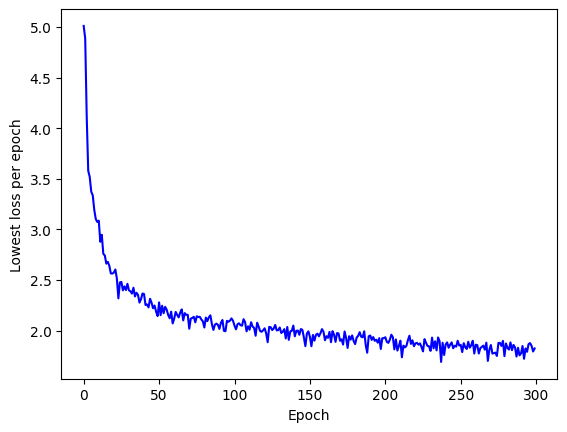

In [19]:
plt.plot(epochList, epochLoss, color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Lowest loss per epoch')
plt.show()

<h2>Evaluating reconstruction capabilities on Test Set

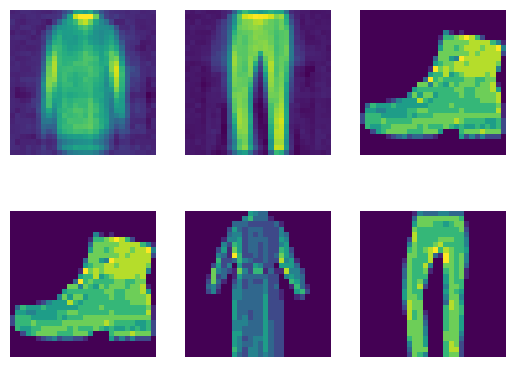

In [20]:
numSamples = 3
randomIndices = random.sample(range(0, len(xTest)), numSamples)
testSamples = list(np.array(xTestFlat)[randomIndices])
latentOutputs = []
reconstructedOutputs = []
displayList = []

vaeModel.eval()
for testImage in testSamples:
    Mean, Variance, decodedOutput = vaeModel(torch.FloatTensor(np.reshape(testImage, (-1,flattenDim))).unsqueeze(0).to(device))
    reconstructedOutputs.append(decodedOutput.cpu().detach().numpy().reshape(28, 28))
displayList = testSamples + reconstructedOutputs
displayImages(displayList, 2, 3)